# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [1]:
# Common libraries
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import os

# Sklearn libraries
# BaseEstimator is a helper class provided by scikit-learn to make it easier to create your own custom models or transformers that behave like 
# any other scikit-learn model. 
# MetaEstimatorMixin is a mixin class from sksklearn.base to help create meta-estimators, which are estimators that wrap other estimators.
from sklearn.base import BaseEstimator, MetaEstimatorMixin, ClassifierMixin
# The clone function creates a new copy of an estimator with the same parameters, but without any trained data, without any fitted attributes. 
from sklearn.base import clone as skclone 
from sklearn.base import is_classifier
from sklearn.ensemble._base import _set_random_states

# Models
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Utils
from sklearn.utils import check_random_state, resample
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.metaestimators import available_if

# Selection classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss)

from sklearn.metrics import classification_report

# Simulation functions
from sklearn.datasets import make_classification, make_blobs
from adspy_shared_utilities import plot_class_regions_for_classifier

# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Data
from sklearn.datasets import load_iris

# SSlearn library
from sslearn.utils import calculate_prior_probability, check_classifier
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.wrapper import Setred

In [2]:
from setred_package import Setred_scratch, simulated_data

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [3]:
X = np.load("data/X.npy")
y = np.load("data/y.npy")
X_unlabel = np.load("data/X_unlabel.npy")
y_unlabel = np.load("data/y_unlabel.npy")
X_ori = np.load("data/X_ori.npy")
y_ori = np.load("data/y_ori.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")

In [4]:
colors = [
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
]
cmap_bold = ListedColormap(colors)



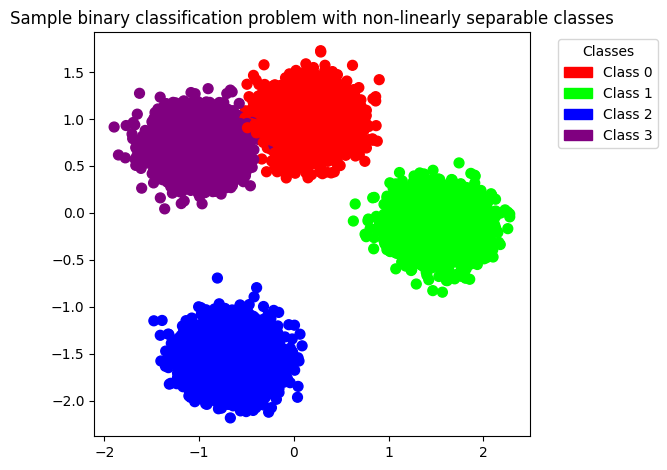

In [5]:
import matplotlib.patches as mpatches
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_ori)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Generation of artificial semisupervised learning


In [6]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False)}")


Shape of X: (9750, 2), y: (9750,), X_unlabel: (9653, 2), y_unlabel: (9653,)
Frequencies of classes in y: -1    9653
 3      30
 0      24
 1      24
 2      19
Name: count, dtype: int64


In [7]:
# Filtering the labeled instances
X_val = X[y != -1]
y_val = y[y != -1]
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False)}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False)}")


Shape of X_val: (97, 2), y_val: (97,), X_test: (3250, 2), y_test: (3250,)
Frequencies of classes in y_val: 3    30
0    24
1    24
2    19
Name: count, dtype: int64
Frequencies of classes in y_test: 0    827
3    822
2    820
1    781
Name: count, dtype: int64


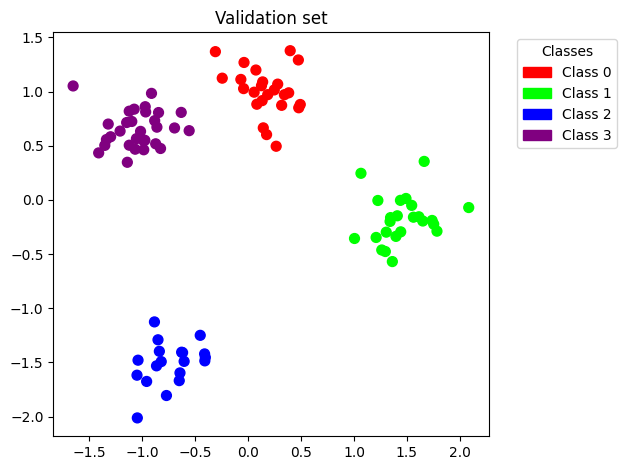

In [8]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

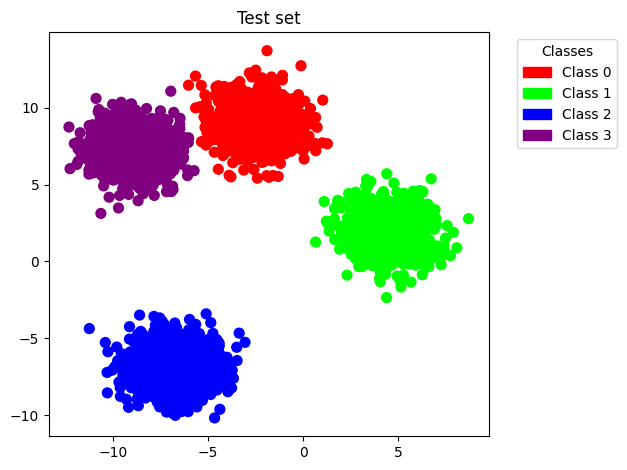

In [9]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)

unique_classes = np.unique(y_test)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Decision Tree

- Hyperparamter tunning with the validation data
- Check the performance of the classifier on the test data

In [10]:
# Fitting a decision tree with hyperparameters tunning using cross validation
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(dt, param_grid, cv=5)
print("The shape of X_val:", X_val.shape)
print("The shape of y_val:", y_val.shape)

grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_dt = DecisionTreeClassifier(**best_params, random_state=42)

The shape of X_val: (97, 2)
The shape of y_val: (97,)
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [11]:
# Fit the base estimator on the validation set
dt_fitted = base_estimator_dt.fit(X_val, y_val)

In [12]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_dt.predict(X_val)
y_test_pred = base_estimator_dt.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 1.0
Accuracy of the base estimator on the test set: 0.544
Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        30

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Classification report on test set:
              precision    recall  f1-score   support

           0       0.05      0.04      0.05       827
           1       1.00      0.12      0.21       781
           2       1.00      1.00      1.00       820
           3       0.51      1.00      0.67       822

    accuracy                           0.54      3250
   macro avg       0.64      0.54      0.48      32

In [13]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_dt.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))


Accuracy of the base estimator on the unlabeled set: 0.9713042577437067
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2399
           1       0.91      1.00      0.95      2445
           2       1.00      0.90      0.95      2411
           3       0.99      1.00      0.99      2398

    accuracy                           0.97      9653
   macro avg       0.97      0.97      0.97      9653
weighted avg       0.97      0.97      0.97      9653



# SETRED CLASSIFIER

In [14]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Decision Tree

In [15]:
# Fitting the Setred classifier
ssl_clf_dt = Setred_scratch(base_estimator=base_estimator_dt,
                         max_iterations=2,
                         graph_neighbors=1,                        
                         htunning=True,
                         param_grid={
                                'max_depth': [None, 5, 10, 15],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4, 5, 15]
                            },
                        X_label_real=X_test,
                        y_label_real=y_test,
                        y_unlabel=y_unlabel,
                        view = 1,
                        messages=True)
ssl_clf_dt.fit(X, y)


Iteration 1 - Accuracy: 0.9708
Iteration 1: Report of the base estimator:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       612
           1       0.92      1.00      0.96       607
           2       1.00      0.91      0.95       593

    accuracy                           0.97      1812
   macro avg       0.97      0.97      0.97      1812
weighted avg       0.97      0.97      0.97      1812

Iteration 1 - 1909 labeled instances, 7841 unlabeled instances left
Distribution of labels in the labeled set:
1    684
0    636
2    559
3     30
Name: count, dtype: int64
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.05      0.05      0.05       827
           1       1.00      0.12      0.22       781
           2       1.00      1.00      1.00       820
           3       0.51      1.00      0.68       822

    accura

Setred_scratch(X_label_real=array([[ -8.55684373,   8.0448222 ],
       [ -7.01012842,  -9.22022379],
       [-10.09432703,   7.70284826],
       ...,
       [ -8.74009415,   7.71467924],
       [  5.30109931,   1.0929912 ],
       [  3.8980863 ,   3.05138373]]),
               base_estimator=DecisionTreeClassifier(random_state=42),
               graph_neighbors=1, htunning=True, max_iterations=2,
               param_grid={'max_depth': [None, 5, 10, 15],
                           'min_samples_leaf': [1, 2, 4, 5, 15],
                           'min_samples_split': [2, 5, 10]},
               view=1, y_label_real=array([3, 2, 3, ..., 3, 1, 1]),
               y_unlabel=array([2, 0, 0, ..., 1, 0, 0]))

In [ ]:
# Plot the accuracy of the Setred classifier
plt.figure(figsize=(10, 6))
plt.plot(ssl_clf_dt.accuracy_, marker='o', linestyle='-', color='b')
plt.title('Setred Classifier Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(len(ssl_clf_dt.accuracy_)))
plt.grid()



# Simulation score

In [ ]:
# Simulation of the accuracy score
score = []
for i in range(100):
    # Fitting the Setred classifier
    ssl_clf_dt = Setred_scratch(base_estimator=base_estimator_dt,
                            max_iterations=40,
                            graph_neighbors=20,                        
                            htunning=False,
                            param_grid={
                                    'max_depth': [None, 5, 10, 15],
                                    'min_samples_split': [2, 5, 10],
                                    'min_samples_leaf': [1, 2, 4]
                                },
                            X_label_real=X_test,
                            y_label_real=y_test,
                            view = 1,
                            messages=False)
    ssl_clf_dt.fit(X, y)
    # Score
    score.append(ssl_clf_dt.score(X_test, y_test))
    

In [ ]:
# Display the accuracy score
print(f"Accuracy score: {np.mean(score)}")
# Line plot 
plt.figure(figsize=(10, 6))
plt.plot(score, marker='o', linestyle='-', color='b')
plt.title('Accuracy Score Over 100 Simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Accuracy Score')
plt.grid()
plt.show()

In [ ]:

score = []
for i in range(100):
    # Fitting the Setred classifier
    clf = Setred(base_estimator=base_estimator_dt,graph_neighbors=20)    
    clf.fit(X, y)
    # Score
    score.append(clf.score(X_test, y_test))
    

In [ ]:
# Display the accuracy score
print(f"Accuracy score: {np.mean(score)}")
# Line plot 
plt.figure(figsize=(10, 6))
plt.plot(score, marker='o', linestyle='-', color='b')
plt.title('Accuracy Score Over 100 Simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Accuracy Score')
plt.grid()
plt.show()

# Evaluation Metric

In [16]:
# Accuracy score
## Base setimiator
y_pred = base_estimator_dt.predict(X_test)
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_pred)}")
accuracy_score_dt = ssl_clf_dt.score(X_test, y_test)
print(f"Accuracy of the Setred classifier on the test set: {accuracy_score_dt}")


Accuracy of the base estimator on the test set: 0.544
Accuracy of the Setred classifier on the test set: 0.5467692307692308


In [17]:
# Generate predictions on the test set
y_pred = ssl_clf_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.06      0.05      0.05       827
           1       1.00      0.12      0.22       781
           2       1.00      1.00      1.00       820
           3       0.51      1.00      0.68       822

    accuracy                           0.55      3250
   macro avg       0.64      0.54      0.49      3250
weighted avg       0.64      0.55      0.49      3250



In [18]:
# Generate predictions on the test set
y_pred = base_estimator_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.05      0.04      0.05       827
           1       1.00      0.12      0.21       781
           2       1.00      1.00      1.00       820
           3       0.51      1.00      0.67       822

    accuracy                           0.54      3250
   macro avg       0.64      0.54      0.48      3250
weighted avg       0.63      0.54      0.48      3250



# Comparison between the trees

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



In [ ]:
plot_tree(base_estimator_dt, feature_names=["f1", "f2"], class_names=["A", "B","C","D","E"], filled=True)
plt.show()

In [ ]:
plot_tree(ssl_clf_dt._base_estimator, feature_names=["f1", "f2"], class_names=["A", "B","C","D","E"], filled=True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Simulate data
X_label = np.array([[0, 0], [1, 1]])            # 2 labeled instances
y_label = np.array([0, 1])

L_ = np.array([[0.1, 0.2], [0.9, 1.1]])         # 2 new confident predictions
y_ = np.array([0, 1])

# Combine
pre_L = np.concatenate((X_label, L_), axis=0)
pre_yL = np.concatenate((y_label, y_), axis=0)

# Simulate weights as distance matrix (for illustration)
from sklearn.metrics.pairwise import euclidean_distances
weights = kneighbors_graph(pre_L, n_neighbors=3, mode="distance", metric='euclidean', n_jobs=-1).toarray()
#weights = euclidean_distances(pre_L, pre_L)

# Create indicator matrix for class disagreement
iid_observed = (pre_yL[:, None] != pre_yL[None, :]).astype(int)

# Keep only L_ vs X_label
weights_reduced = weights[-L_.shape[0]:, :X_label.shape[0]]
iid_reduced = iid_observed[-L_.shape[0]:, :X_label.shape[0]]

print("weights:\n", weights_reduced)
print("iid_observed:\n", iid_reduced)


In [ ]:
pre_L

In [ ]:
weights

In [ ]:
np.sqrt(0.1**2 + 0.2**2)